In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf

from tensorflow.keras.applications import InceptionV3, Xception, ResNet152V2,InceptionResNetV2, MobileNetV2, EfficientNetB0 
from tensorflow.keras.optimizers import Adam, SGD

from sklearn.metrics import classification_report, roc_curve,precision_recall_curve, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
import pandas as pd
import numpy as np
import os.path
import matplotlib.pyplot as plt
import seaborn as sns
import gc

from PIL import Image
from tensorflow import keras 
from tensorflow.keras.applications import ResNet50,ResNet101
import cv2
#from tqdm import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras import applications
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import StratifiedKFold , KFold ,RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from plotly import graph_objects as go
import matplotlib.pyplot as plt
from collections import Counter
from PIL import Image
import cv2
import numpy as np
import pandas as pd
import io
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from mlflow_extend import mlflow
import tensorflow.compat.v1 as tf
physical_devices=tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0],True)
#TRAIN_PATH='C:/Users/edramos/Documents/AI Manufacturing/Allegion Training/1. Image Classification with Transfer learning - ConvNets/ADCO_Baseplates.v16i.folder/train'
#TRAIN_PATH='C:/Users/edramos/Documents/AI Manufacturing/Allegion Training/1. Image Classification with Transfer learning - ConvNets/ADCO_Baseplates.v16i.folder/train'
TRAIN_PATH='C:/Users/edramos/Documents/AI Manufacturing/Allegion Training/1. Image Classification with Transfer learning - ConvNets/Baseplates/Train/'
#VALIDATION_DATA_DIR='C:/Users/edramos/Documents/datasets/Baseplates/Validation'
TESTING_DATA_DIR='C:/Users/edramos/Documents/AI Manufacturing/Allegion Training/1. Image Classification with Transfer learning - ConvNets/Baseplates/Validation/' # 'C:/Users/edramos/Documents//AI Manufacturing/Allegion Training/1. Image Classification with Transfer learning - ConvNets/Control-Fixtura/Testing'
#VALIDATION_DATA_DIR='C:/Users/edramos/Documents/AI Manufacturing/Allegion Training/1. Image Classification with Transfer learning - ConvNets/ADCO_Baseplates.v16i.folder/valid'
#VALIDATION_DATA_DIR='C:/Users/edramos/Documents/AI Manufacturing/Allegion Training/1. Image Classification with Transfer learning - ConvNets/ADCO_Baseplates.v16i.folder/valid'

IMG_SIZE = 299
BATCH_SIZE =8
datagen_kwargs = dict(rescale=1./255,rotation_range=10,
        shear_range=0.1,
        zoom_range=0.1,
        brightness_range=[0,1],
        horizontal_flip=True)

def testGen(IMG_SIZE):
  test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.0)
  test_data_dir=TESTING_DATA_DIR
  Test_generator = test_datagen.flow_from_directory(
        test_data_dir,
        target_size=(IMG_SIZE,IMG_SIZE),
        batch_size=1,
        class_mode='categorical',
        shuffle=False)
        
  return Test_generator

def test(loaded_model):

    Images4ValidationGenerator=testGen(IMG_SIZE)
    y_test=Images4ValidationGenerator.classes
    class_labels = Images4ValidationGenerator.class_indices
    class_labels = {v: k for k, v in class_labels.items()}
    classes = list(class_labels.values())
    y_true = Images4ValidationGenerator.classes
    Y_pred = loaded_model.predict(Images4ValidationGenerator)
    y_pred = np.argmax(Y_pred, axis=1)

    conf_mat = confusion_matrix(y_true,y_pred)
    conf_mat_normalized = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
    fig1=plt.figure(figsize = (10,10))
    sns.heatmap(conf_mat, annot=True,fmt='d',cmap="Blues")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


    test_acc = accuracy_score(y_true, y_pred)
    test_f1 = f1_score(y_true, y_pred, average='macro')  
    test_precision = precision_score(y_true, y_pred, average='macro')
    test_recall = recall_score(y_true, y_pred, average='macro')
    print("Test Accuracy: {0:.2f}".format(test_acc))
    print("Test f1: {0:.2f}".format(test_f1))
    print("Test Precision: {0:.2f}".format(test_precision))
    print("Test Recall: {0:.2f}".format(test_recall))
    mlflow.log_metric("Test Accuracy", test_acc)
    mlflow.log_metric("Test F1", test_f1)
    mlflow.log_metric("Test Precision", test_precision)
    mlflow.log_metric("Test Recall", test_recall)
   

    # get confusion matrix values
  
    conf_matrix = confusion_matrix(y_true,y_pred)
    true_positive = conf_matrix[0][0]
    true_negative = conf_matrix[1][1]
    false_positive = conf_matrix[0][1]
    false_negative = conf_matrix[1][0]

    mlflow.log_metric("true_positive", true_positive)
    mlflow.log_metric("true_negative", true_negative)
    mlflow.log_metric("false_positive", false_positive)
    mlflow.log_metric("false_negative", false_negative)
    mlflow.log_confusion_matrix(conf_matrix)



    print("Model saved in run %s" % mlflow.active_run().info.run_uuid)#mlflow.get_run('b814f5204f724610bb551bf8322d45ec')) #mlflow.active_run().info.run_uuid)


train = pd.read_csv('C:/Users/edramos/Documents/AI Manufacturing/Allegion Training/1. Image Classification with Transfer learning - ConvNets/Baseplates/train/dataset.csv')
train.head()

# As we are going to divide dataset
df = train.copy()


# Increasing the size of dataset

AD_CYL = train[train["Class"]=='AD_CYL']
AD_MS = train[train["Class"]=='AD_MS']
CO_CYL = train[train["Class"]=='CO_CYL']
CO_MS = train[train["Class"]=='CO_MS']
EXIT = train[train["Class"]=='EXIT']
TRAY_ONLY = train[train["Class"]=='TRAY_ONLY']

df = pd.concat([df,AD_CYL])
df = pd.concat([df,AD_MS])
df = pd.concat([df,CO_CYL])
df = pd.concat([df,CO_MS])
df = pd.concat([df,EXIT])
df = pd.concat([df,TRAY_ONLY])


# Creating X, Y for training 

train_y = df.Class
train_x = df.drop(['Class'],axis=1)

EPOCHS = 10
N_SPLIT = 7


print(df['Image'][50])

datagen_kwargs2 = dict(rescale=1./255)

train_datagen = ImageDataGenerator(**datagen_kwargs2)
validation_datagen = ImageDataGenerator(**datagen_kwargs2)

def Create_Images_for_training(shape_size_W,shape_size_H,**datagen_kwargs):

  IMAGE_SHAPE=(shape_size_W, shape_size_H)
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
  train_generator = train_datagen.flow_from_directory(
  TRAIN_PATH,
  batch_size=32,
  subset="training",
  seed=42,
  shuffle=True,
  target_size=IMAGE_SHAPE)
  for image_batch, label_batch in train_generator:
    break
  print(image_batch.shape, label_batch.shape)
  image_batch_train, label_batch_train = next(iter(train_generator))
  valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
  valid_generator = valid_datagen.flow_from_directory(
  TRAIN_PATH,
  subset="validation",
  shuffle=True,
  target_size=IMAGE_SHAPE
  )
  val_image_batch, val_label_batch = next(iter(valid_generator))
  print("Image batch shape: ", image_batch_train.shape)
  print("Label batch shape: ", label_batch_train.shape)
  dataset_labels = sorted(train_generator.class_indices.items(), key=lambda pair:pair[1])
  dataset_labels = np.array([key.title() for key, value in dataset_labels])
  print(dataset_labels)
  
  print(label_batch[0:5])
  print(train_generator.class_indices)
  labels = '\n'.join(sorted(train_generator.class_indices.keys()))
  with open('labels.txt', 'w') as f:
    f.write(labels)
  return train_generator,valid_generator,dataset_labels



C:\Users\edramos\Documents\AI Manufacturing\Allegion Training\1. Image Classification with Transfer learning - ConvNets\Baseplates\Train/Class1/144.jpg


Found 3995 images belonging to 6 classes.
(32, 299, 299, 3) (32, 6)
Found 0 images belonging to 6 classes.
Image batch shape:  (32, 299, 299, 3)
Label batch shape:  (32, 6)
['Class1' 'Class2' 'Class3' 'Class4' 'Class5' 'Class6']
[[0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0.]]
{'Class1': 0, 'Class2': 1, 'Class3': 2, 'Class4': 3, 'Class5': 4, 'Class6': 5}


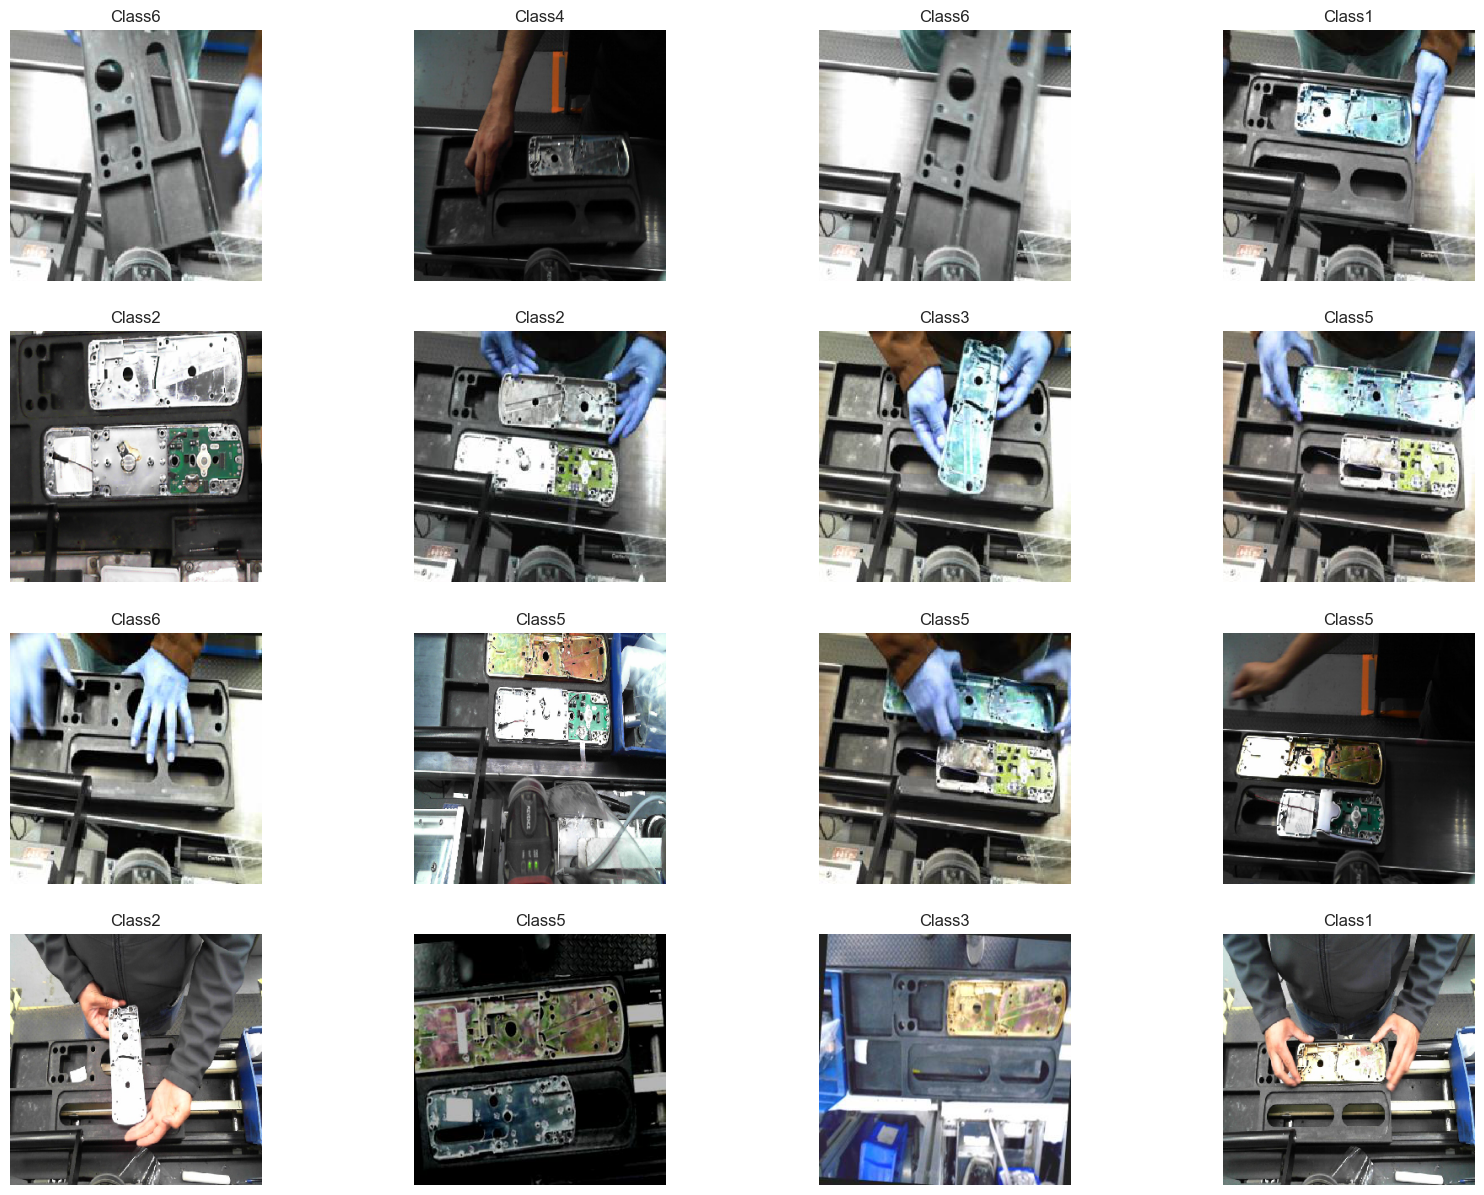

In [56]:
train_generator,valid_generator,dataset_labels=Create_Images_for_training(299,299,**datagen_kwargs2)
class_names = dataset_labels
image_batch, label_batch = next(iter(train_generator))

plt.figure(figsize=(20, 15))
for i in range(16):
  ax = plt.subplot(4, 4, i + 1)
  plt.imshow(np.array(image_batch[i]))
  label = np.argmax(label_batch[i])
  plt.title(class_names[label])
  plt.axis("off")

Augmenting Images

Found 3995 images belonging to 6 classes.
(32, 299, 299, 3) (32, 6)
Found 0 images belonging to 6 classes.
Image batch shape:  (32, 299, 299, 3)
Label batch shape:  (32, 6)
['Class1' 'Class2' 'Class3' 'Class4' 'Class5' 'Class6']
[[0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0.]]
{'Class1': 0, 'Class2': 1, 'Class3': 2, 'Class4': 3, 'Class5': 4, 'Class6': 5}


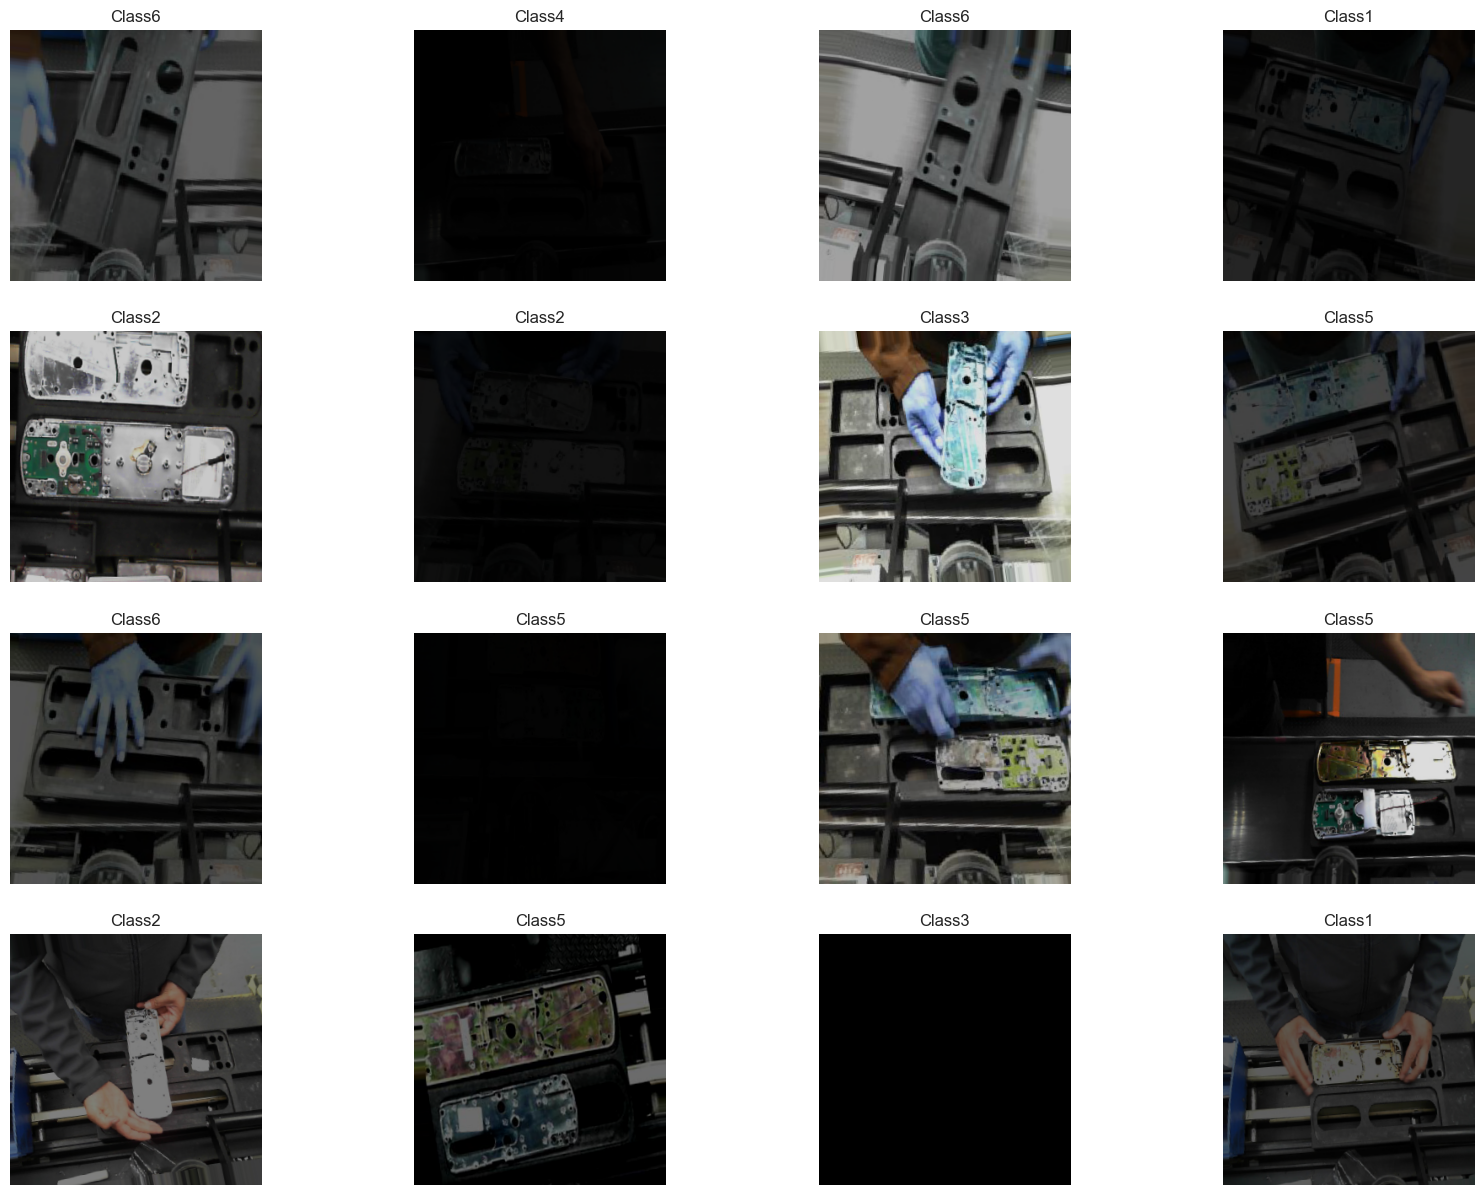

In [57]:
train_generator,valid_generator,dataset_labels=Create_Images_for_training(299,299,**datagen_kwargs)
class_names = dataset_labels
image_batch, label_batch = next(iter(train_generator))

plt.figure(figsize=(20, 15))
for i in range(16):
  ax = plt.subplot(4, 4, i + 1)
  plt.imshow(np.array(image_batch[i]))
  label = np.argmax(label_batch[i])
  plt.title(class_names[label])
  plt.axis("off")

In [2]:

print(df['Image'][50])

50    C:\Users\edramos\Documents\AI Manufacturing\Al...
50    C:\Users\edramos\Documents\AI Manufacturing\Al...
Name: Image, dtype: object


2022/10/26 18:16:53 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of tensorflow. If you encounter errors during autologging, try upgrading / downgrading tensorflow to a supported version, or try upgrading MLflow.


experiment_id: 10
Found 3423 validated image filenames belonging to 6 classes.
Found 572 validated image filenames belonging to 6 classes.


c:\Users\edramos\Anaconda3\envs\mlflow\lib\site-packages\keras\preprocessing\image.py:1139: UserWarning: Found 6 invalid image filename(s) in x_col="Image". These filename(s) will be ignored.
  warnings.warn(


Epoch 1/10
  6/428 [..............................] - ETA: 1:44 - loss: 2.3934 - tp: 2.0000 - fp: 14.0000 - tn: 226.0000 - fn: 46.0000 - precision: 0.1250 - recall: 0.0417 - acc: 0.1250 - auc: 0.4836 - specificity_at_sensitivity_4: 0.4542 - sensitivity_at_specificity_4: 0.4583WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.1238s vs `on_train_batch_end` time: 0.1373s). Check your callbacks.


428/428 [==============================] - 6218s 15s/step - loss: 1.5165 - tp: 470.0000 - fp: 184.0000 - tn: 16931.0000 - fn: 2953.0000 - precision: 0.7187 - recall: 0.1373 - acc: 0.3725 - auc: 0.7323 - specificity_at_sensitivity_4: 0.7809 - sensitivity_at_specificity_4: 0.7943 - val_loss: 0.8815 - val_tp: 235.0000 - val_fp: 23.0000 - val_tn: 2837.0000 - val_fn: 337.0000 - val_precision: 0.9109 - val_recall: 0.4108 - val_acc: 0.7343 - val_auc: 0.9384 - val_specificity_at_sensitivity_4: 0.9864 - val_sensitivity_at_specificity_4: 0.9860
Epoch 2/10
428/428 [==============================] - 197s 459ms/step - loss: 0.8369 - tp: 1857.0000 - fp: 413.0000 - tn: 16702.0000 - fn: 1566.0000 - precision: 0.8181 - recall: 0.5425 - acc: 0.6798 - auc: 0.9296 - specificity_at_sensitivity_4: 0.9825 - sensitivity_at_specificity_4: 0.9895 - val_loss: 0.3773 - val_tp: 469.0000 - val_fp: 28.0000 - val_tn: 2832.0000 - val_fn: 103.0000 - val_precision: 0.9437 - val_recall: 0.8199 - val_acc: 0.8724 - val_auc

INFO:tensorflow:Assets written to: C:\Users\edramos\AppData\Local\Temp\tmpj8_3vjl_\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\edramos\AppData\Local\Temp\tmpj8_3vjl_\model\data\model\assets
2022/10/26 20:34:26 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: could not create '.\artifacts\10\858ab37664d4443897e5e7c5b142529c\artifacts\tensorboard_logs\validation\events.out.tfevents.1666839609.ENS-AL-FJ5P893.39868.43.v2': No such file or directory


Found 3426 validated image filenames belonging to 6 classes.
Found 569 validated image filenames belonging to 6 classes.


c:\Users\edramos\Anaconda3\envs\mlflow\lib\site-packages\keras\preprocessing\image.py:1139: UserWarning: Found 3 invalid image filename(s) in x_col="Image". These filename(s) will be ignored.
  warnings.warn(
c:\Users\edramos\Anaconda3\envs\mlflow\lib\site-packages\keras\preprocessing\image.py:1139: UserWarning: Found 3 invalid image filename(s) in x_col="Image". These filename(s) will be ignored.
  warnings.warn(


Epoch 1/10
  6/428 [..............................] - ETA: 1:44 - loss: 2.3411 - tp: 557.0000 - fp: 15.0000 - tn: 3085.0000 - fn: 63.0000 - precision: 0.9738 - recall: 0.8984 - acc: 0.9177 - auc: 0.9927 - specificity_at_sensitivity_4: 0.9997 - sensitivity_at_specificity_4: 0.9952WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.1339s vs `on_train_batch_end` time: 0.1395s). Check your callbacks.


428/428 [==============================] - 220s 495ms/step - loss: 1.6761 - tp: 773.0000 - fp: 150.0000 - tn: 19800.0000 - fn: 3217.0000 - precision: 0.8375 - recall: 0.1937 - acc: 0.3870 - auc: 0.7402 - specificity_at_sensitivity_4: 0.7863 - sensitivity_at_specificity_4: 0.7787 - val_loss: 1.2198 - val_tp: 130.0000 - val_fp: 22.0000 - val_tn: 2823.0000 - val_fn: 439.0000 - val_precision: 0.8553 - val_recall: 0.2285 - val_acc: 0.5378 - val_auc: 0.8611 - val_specificity_at_sensitivity_4: 0.9381 - val_sensitivity_at_specificity_4: 0.9385
Epoch 2/10
428/428 [==============================] - 220s 513ms/step - loss: 1.0422 - tp: 1414.0000 - fp: 368.0000 - tn: 16722.0000 - fn: 2004.0000 - precision: 0.7935 - recall: 0.4137 - acc: 0.5957 - auc: 0.8883 - specificity_at_sensitivity_4: 0.9604 - sensitivity_at_specificity_4: 0.9649 - val_loss: 0.4862 - val_tp: 437.0000 - val_fp: 40.0000 - val_tn: 2805.0000 - val_fn: 132.0000 - val_precision: 0.9161 - val_recall: 0.7680 - val_acc: 0.8506 - val_au

INFO:tensorflow:Assets written to: C:\Users\edramos\AppData\Local\Temp\tmp86g6h6w_\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\edramos\AppData\Local\Temp\tmp86g6h6w_\model\data\model\assets
2022/10/26 21:12:02 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: could not create '.\artifacts\10\858ab37664d4443897e5e7c5b142529c\artifacts\tensorboard_logs\validation\events.out.tfevents.1666841857.ENS-AL-FJ5P893.39868.45.v2': No such file or directory


Found 3423 validated image filenames belonging to 6 classes.
Found 572 validated image filenames belonging to 6 classes.


c:\Users\edramos\Anaconda3\envs\mlflow\lib\site-packages\keras\preprocessing\image.py:1139: UserWarning: Found 6 invalid image filename(s) in x_col="Image". These filename(s) will be ignored.
  warnings.warn(


Epoch 1/10
428/428 [==============================] - 231s 521ms/step - loss: 1.4913 - tp: 1078.0000 - fp: 251.0000 - tn: 19709.0000 - fn: 2914.0000 - precision: 0.8111 - recall: 0.2700 - acc: 0.4687 - auc: 0.8120 - specificity_at_sensitivity_4: 0.8856 - sensitivity_at_specificity_4: 0.8895 - val_loss: 0.8223 - val_tp: 278.0000 - val_fp: 39.0000 - val_tn: 2821.0000 - val_fn: 294.0000 - val_precision: 0.8770 - val_recall: 0.4860 - val_acc: 0.6976 - val_auc: 0.9433 - val_specificity_at_sensitivity_4: 0.9832 - val_sensitivity_at_specificity_4: 0.9983
Epoch 2/10
428/428 [==============================] - 226s 528ms/step - loss: 0.8234 - tp: 1874.0000 - fp: 455.0000 - tn: 16660.0000 - fn: 1549.0000 - precision: 0.8046 - recall: 0.5475 - acc: 0.6795 - auc: 0.9321 - specificity_at_sensitivity_4: 0.9800 - sensitivity_at_specificity_4: 0.9907 - val_loss: 0.2763 - val_tp: 502.0000 - val_fp: 16.0000 - val_tn: 2844.0000 - val_fn: 70.0000 - val_precision: 0.9691 - val_recall: 0.8776 - val_acc: 0.91

INFO:tensorflow:Assets written to: C:\Users\edramos\AppData\Local\Temp\tmpufatnhyb\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\edramos\AppData\Local\Temp\tmpufatnhyb\model\data\model\assets
2022/10/26 21:55:09 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: could not create '.\artifacts\10\858ab37664d4443897e5e7c5b142529c\artifacts\tensorboard_logs\validation\events.out.tfevents.1666844126.ENS-AL-FJ5P893.39868.47.v2': No such file or directory


Found 3423 validated image filenames belonging to 6 classes.
Found 572 validated image filenames belonging to 6 classes.


c:\Users\edramos\Anaconda3\envs\mlflow\lib\site-packages\keras\preprocessing\image.py:1139: UserWarning: Found 6 invalid image filename(s) in x_col="Image". These filename(s) will be ignored.
  warnings.warn(


Epoch 1/10
428/428 [==============================] - 203s 452ms/step - loss: 1.6418 - tp: 869.0000 - fp: 213.0000 - tn: 19762.0000 - fn: 3126.0000 - precision: 0.8031 - recall: 0.2175 - acc: 0.4100 - auc: 0.7577 - specificity_at_sensitivity_4: 0.8125 - sensitivity_at_specificity_4: 0.8215 - val_loss: 1.0865 - val_tp: 146.0000 - val_fp: 18.0000 - val_tn: 2842.0000 - val_fn: 426.0000 - val_precision: 0.8902 - val_recall: 0.2552 - val_acc: 0.6888 - val_auc: 0.9106 - val_specificity_at_sensitivity_4: 0.9699 - val_sensitivity_at_specificity_4: 0.9650
Epoch 2/10
428/428 [==============================] - 210s 490ms/step - loss: 0.9266 - tp: 1705.0000 - fp: 440.0000 - tn: 16675.0000 - fn: 1718.0000 - precision: 0.7949 - recall: 0.4981 - acc: 0.6313 - auc: 0.9126 - specificity_at_sensitivity_4: 0.9739 - sensitivity_at_specificity_4: 0.9807 - val_loss: 0.3667 - val_tp: 470.0000 - val_fp: 28.0000 - val_tn: 2832.0000 - val_fn: 102.0000 - val_precision: 0.9438 - val_recall: 0.8217 - val_acc: 0.89

INFO:tensorflow:Assets written to: C:\Users\edramos\AppData\Local\Temp\tmpk4juo4zb\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\edramos\AppData\Local\Temp\tmpk4juo4zb\model\data\model\assets
2022/10/26 22:29:49 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: could not create '.\artifacts\10\858ab37664d4443897e5e7c5b142529c\artifacts\tensorboard_logs\validation\events.out.tfevents.1666846683.ENS-AL-FJ5P893.39868.49.v2': No such file or directory


Found 3424 validated image filenames belonging to 6 classes.
Found 571 validated image filenames belonging to 6 classes.


c:\Users\edramos\Anaconda3\envs\mlflow\lib\site-packages\keras\preprocessing\image.py:1139: UserWarning: Found 6 invalid image filename(s) in x_col="Image". These filename(s) will be ignored.
  warnings.warn(


Epoch 1/10
428/428 [==============================] - 189s 426ms/step - loss: 1.5913 - tp: 900.0000 - fp: 162.0000 - tn: 19818.0000 - fn: 3096.0000 - precision: 0.8475 - recall: 0.2252 - acc: 0.4254 - auc: 0.7757 - specificity_at_sensitivity_4: 0.8470 - sensitivity_at_specificity_4: 0.8418 - val_loss: 0.9951 - val_tp: 185.0000 - val_fp: 11.0000 - val_tn: 2844.0000 - val_fn: 386.0000 - val_precision: 0.9439 - val_recall: 0.3240 - val_acc: 0.6760 - val_auc: 0.9217 - val_specificity_at_sensitivity_4: 0.9828 - val_sensitivity_at_specificity_4: 0.9720
Epoch 2/10
428/428 [==============================] - 191s 445ms/step - loss: 0.9099 - tp: 1692.0000 - fp: 423.0000 - tn: 16697.0000 - fn: 1732.0000 - precision: 0.8000 - recall: 0.4942 - acc: 0.6425 - auc: 0.9168 - specificity_at_sensitivity_4: 0.9739 - sensitivity_at_specificity_4: 0.9877 - val_loss: 0.4130 - val_tp: 467.0000 - val_fp: 33.0000 - val_tn: 2822.0000 - val_fn: 104.0000 - val_precision: 0.9340 - val_recall: 0.8179 - val_acc: 0.87

INFO:tensorflow:Assets written to: C:\Users\edramos\AppData\Local\Temp\tmpawckfn99\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\edramos\AppData\Local\Temp\tmpawckfn99\model\data\model\assets
2022/10/26 23:02:30 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: could not create '.\artifacts\10\858ab37664d4443897e5e7c5b142529c\artifacts\tensorboard_logs\validation\events.out.tfevents.1666848754.ENS-AL-FJ5P893.39868.51.v2': No such file or directory


Found 3425 validated image filenames belonging to 6 classes.
Found 570 validated image filenames belonging to 6 classes.


c:\Users\edramos\Anaconda3\envs\mlflow\lib\site-packages\keras\preprocessing\image.py:1139: UserWarning: Found 5 invalid image filename(s) in x_col="Image". These filename(s) will be ignored.
  warnings.warn(
c:\Users\edramos\Anaconda3\envs\mlflow\lib\site-packages\keras\preprocessing\image.py:1139: UserWarning: Found 1 invalid image filename(s) in x_col="Image". These filename(s) will be ignored.
  warnings.warn(


Epoch 1/10
  6/428 [..............................] - ETA: 1:42 - loss: 2.4746 - tp: 564.0000 - fp: 17.0000 - tn: 3078.0000 - fn: 55.0000 - precision: 0.9707 - recall: 0.9111 - acc: 0.9257 - auc: 0.9949 - specificity_at_sensitivity_4: 1.0000 - sensitivity_at_specificity_4: 1.0000WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.1282s vs `on_train_batch_end` time: 0.1298s). Check your callbacks.


428/428 [==============================] - 187s 420ms/step - loss: 1.5058 - tp: 1065.0000 - fp: 217.0000 - tn: 19723.0000 - fn: 2923.0000 - precision: 0.8307 - recall: 0.2671 - acc: 0.4539 - auc: 0.8052 - specificity_at_sensitivity_4: 0.8759 - sensitivity_at_specificity_4: 0.8759 - val_loss: 0.8959 - val_tp: 242.0000 - val_fp: 18.0000 - val_tn: 2832.0000 - val_fn: 328.0000 - val_precision: 0.9308 - val_recall: 0.4246 - val_acc: 0.6947 - val_auc: 0.9405 - val_specificity_at_sensitivity_4: 0.9842 - val_sensitivity_at_specificity_4: 0.9912
Epoch 2/10
428/428 [==============================] - 189s 443ms/step - loss: 0.8272 - tp: 1892.0000 - fp: 384.0000 - tn: 16701.0000 - fn: 1525.0000 - precision: 0.8313 - recall: 0.5537 - acc: 0.6866 - auc: 0.9314 - specificity_at_sensitivity_4: 0.9830 - sensitivity_at_specificity_4: 0.9903 - val_loss: 0.3180 - val_tp: 489.0000 - val_fp: 29.0000 - val_tn: 2821.0000 - val_fn: 81.0000 - val_precision: 0.9440 - val_recall: 0.8579 - val_acc: 0.8947 - val_au

INFO:tensorflow:Assets written to: C:\Users\edramos\AppData\Local\Temp\tmpb9uk4ojm\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\edramos\AppData\Local\Temp\tmpb9uk4ojm\model\data\model\assets
2022/10/26 23:34:57 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: could not create '.\artifacts\10\858ab37664d4443897e5e7c5b142529c\artifacts\tensorboard_logs\validation\events.out.tfevents.1666850714.ENS-AL-FJ5P893.39868.53.v2': No such file or directory


Found 3426 validated image filenames belonging to 6 classes.
Found 569 validated image filenames belonging to 6 classes.


c:\Users\edramos\Anaconda3\envs\mlflow\lib\site-packages\keras\preprocessing\image.py:1139: UserWarning: Found 4 invalid image filename(s) in x_col="Image". These filename(s) will be ignored.
  warnings.warn(
c:\Users\edramos\Anaconda3\envs\mlflow\lib\site-packages\keras\preprocessing\image.py:1139: UserWarning: Found 2 invalid image filename(s) in x_col="Image". These filename(s) will be ignored.
  warnings.warn(


Epoch 1/10
428/428 [==============================] - 185s 416ms/step - loss: 1.4111 - tp: 1246.0000 - fp: 302.0000 - tn: 19638.0000 - fn: 2742.0000 - precision: 0.8049 - recall: 0.3124 - acc: 0.5088 - auc: 0.8366 - specificity_at_sensitivity_4: 0.9162 - sensitivity_at_specificity_4: 0.9195 - val_loss: 0.7349 - val_tp: 313.0000 - val_fp: 34.0000 - val_tn: 2811.0000 - val_fn: 256.0000 - val_precision: 0.9020 - val_recall: 0.5501 - val_acc: 0.7627 - val_auc: 0.9572 - val_specificity_at_sensitivity_4: 0.9919 - val_sensitivity_at_specificity_4: 0.9982
Epoch 2/10
428/428 [==============================] - 189s 441ms/step - loss: 0.7511 - tp: 2068.0000 - fp: 441.0000 - tn: 16649.0000 - fn: 1350.0000 - precision: 0.8242 - recall: 0.6050 - acc: 0.7074 - auc: 0.9433 - specificity_at_sensitivity_4: 0.9878 - sensitivity_at_specificity_4: 0.9915 - val_loss: 0.2965 - val_tp: 489.0000 - val_fp: 19.0000 - val_tn: 2826.0000 - val_fn: 80.0000 - val_precision: 0.9626 - val_recall: 0.8594 - val_acc: 0.90

INFO:tensorflow:Assets written to: C:\Users\edramos\AppData\Local\Temp\tmp5iofdq5a\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\edramos\AppData\Local\Temp\tmp5iofdq5a\model\data\model\assets
2022/10/27 00:07:14 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: could not create '.\artifacts\10\858ab37664d4443897e5e7c5b142529c\artifacts\tensorboard_logs\validation\events.out.tfevents.1666852659.ENS-AL-FJ5P893.39868.55.v2': No such file or directory


Found 77 images belonging to 6 classes.
77/77 [==============================] - 4s 31ms/step
Test Accuracy: 0.97
Test f1: 0.97
Test Precision: 0.97
Test Recall: 0.97
Model saved in run 858ab37664d4443897e5e7c5b142529c


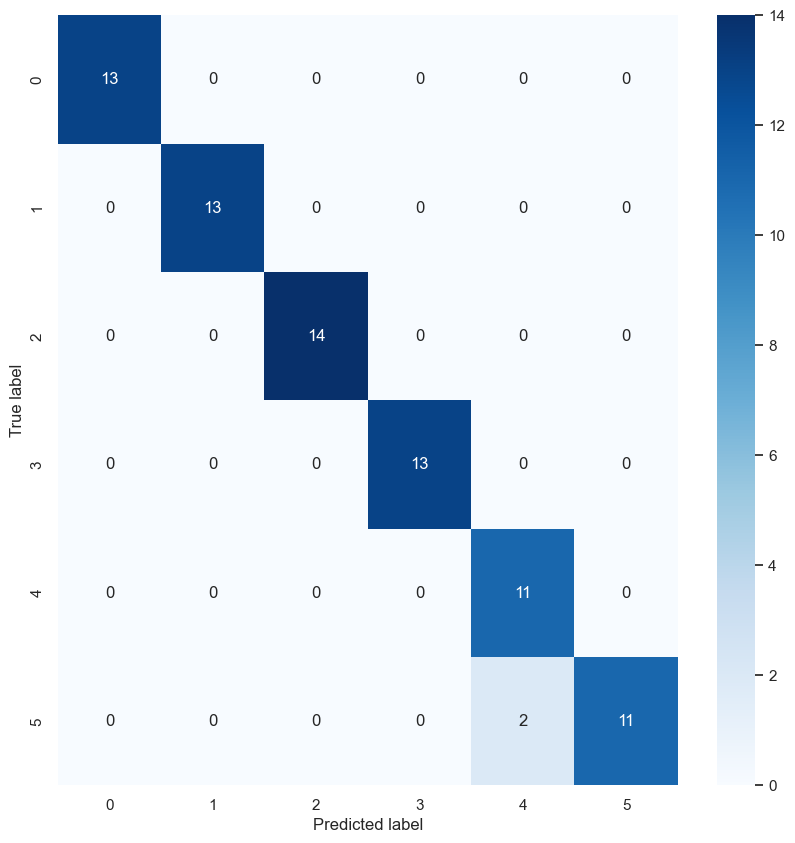

In [21]:

METRICS = [
  tf.keras.metrics.TruePositives(name='tp'),
  tf.keras.metrics.FalsePositives(name='fp'),
  tf.keras.metrics.TrueNegatives(name='tn'),
  tf.keras.metrics.FalseNegatives(name='fn'), 
  tf.keras.metrics.Precision(name='precision'),
  tf.keras.metrics.Recall(name='recall'),
  tf.keras.metrics.CategoricalAccuracy(name='acc'),
  tf.keras.metrics.AUC(name='auc'),
  tf.keras.metrics.SpecificityAtSensitivity(0.5),
  tf.keras.metrics.SensitivityAtSpecificity(0.5),
]

def get_model(IMG_SIZE):
    base_model =applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
    add_model = Sequential()
    add_model.add(Flatten(input_shape=base_model.output_shape[1:]))
    add_model.add(Dropout(0.3))
    add_model.add(Dense(64, activation='relu')
    )
    add_model.add(Dropout(0.4))

    add_model.add(Dense(6, activation='softmax'))

    model = Model(inputs=base_model.input, outputs=add_model(base_model.output))

    model.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(learning_rate=1e-4, momentum=0.9),
                  metrics=METRICS)
    return model

main_pred = []
error = []
data_kfold = pd.DataFrame()

#mlflow.set_tracking_uri("http://10.96.74.220:1234")
#sftp_uri="http://10.96.74.220:1234"
mlflow.set_tracking_uri("http://localhost:1234")
EXPERIMENT_NAME='ADCO - BASEPLATES'

#EXPERIMENT_NAME='my_experiment2'
mlflow.set_experiment(EXPERIMENT_NAME)
#mlflow.create_experiment("my_experiment2", artifact_location=sftp_uri)
experiment=mlflow.get_experiment_by_name(EXPERIMENT_NAME)
print("experiment_id:", experiment.experiment_id)
mlflow.tensorflow.autolog()





# Place tensors on the GPU

with mlflow.start_run(experiment_id=experiment.experiment_id,run_name="Run: ADCO BASEPLATES"):
   
    train_datagen = ImageDataGenerator(**datagen_kwargs)
    validation_datagen = ImageDataGenerator(**datagen_kwargs)

    # k-fold
    kfold = StratifiedKFold(n_splits=N_SPLIT,shuffle=True,random_state=42)

    # Variable for keeping count of split we are executing
    j = 0

    # K-fold Train and test for each split
    for train_idx, val_idx in list(kfold.split(train_x,train_y)):
        #
        x_train_df = df.iloc[train_idx]
        x_valid_df = df.iloc[val_idx]
        j+=1


        training_set = train_datagen.flow_from_dataframe(dataframe=x_train_df, train_dir=None,# directory=TRAIN_PATH,
                                                    x_col="Image", y_col="Class",shuffle=True,
                                                    class_mode="categorical",validate_filenames=True,
                                                    target_size=(IMG_SIZE,IMG_SIZE), batch_size=BATCH_SIZE)
        
        validation_set = validation_datagen.flow_from_dataframe(dataframe=x_valid_df, train_dir=None,# directory=TRAIN_PATH,
                                                    x_col="Image", y_col="Class",shuffle=False ,
                                                    class_mode="categorical",validate_filenames=True,
                                                    target_size=(IMG_SIZE,IMG_SIZE), batch_size=BATCH_SIZE)
        
        model_test = get_model(IMG_SIZE)
        

        history = model_test.fit( training_set,
                                            validation_data=validation_set,
                                            #workers=4,
                                            epochs = EPOCHS,#,,callbacks=[WandbCallback()],
                                            steps_per_epoch=x_train_df.shape[0] // BATCH_SIZE
                                            )
        
        
        gc.collect()
    test(model_test)

Found 240 images belonging to 6 classes.
240/240 [==============================] - 6s 24ms/step
Test Accuracy: 1.00
Test f1: 1.00
Test Precision: 1.00
Test Recall: 1.00
Model saved in run 4b4d887c916a4cbbb0c59e9b851072d6


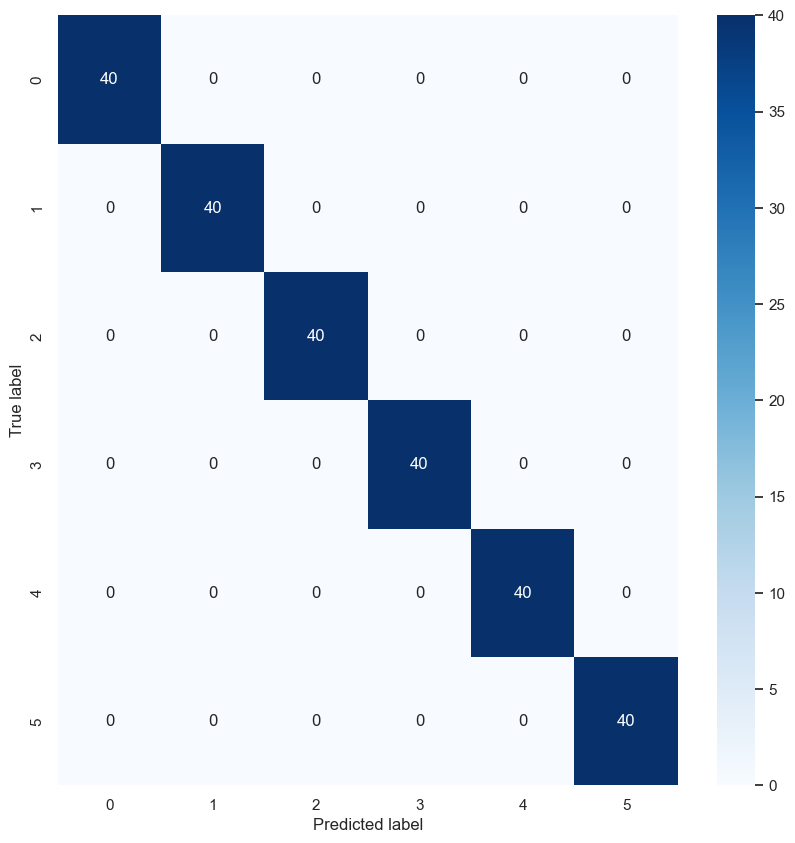

In [28]:
test(model_test)


In [20]:
mlflow.end_run()